##  import など

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display,HTML,Image
import re

In [2]:
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
nltk.download('stopwords')#Stopwods辞書
nltk.download('wordnet')#Lemmatization用。
nltk.download('punkt')#適切に単語分割してくれるTokenizer
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/macico/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/macico/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/macico/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
import gensim
from gensim import corpora
from gensim.corpora import Dictionary


### 便利フォーマットなど

In [4]:
%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format

## 役立つリンク集
- https://hibiki-press.tech/learn_prog/python/format/1015#format
- https://qiita.com/NTeTN/items/ae973bfedfff248e4de6

# 下準備

In [5]:
read_file = "./data/AB_NYC_2019.csv"

In [6]:
df = pd.read_csv(read_file)

In [7]:
df.head()

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington     40.65     -73.97   
1     Jennifer           Manhattan       Midtown     40.75     -73.98   
2    Elisabeth           Manhattan        Harlem     40.81     -73.94   
3  LisaRoxanne            Brooklyn  Clinton Hill     40.69     -73.96   
4        Laura           Manhattan   East Harlem     40.80     -73.94   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
2                nan                               1               365  
3               4.64                               1               194  
4               0.10                               1                 0

In [8]:
df.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [9]:
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

## 欠損値補完

### Name

- 緯度と経度が同じであるとNameは一緒であるとみた

In [10]:
df[df.name.isnull()]

id name   host_id host_name neighbourhood_group  \
2854    1615764  NaN   6676776     Peter           Manhattan   
3703    2232600  NaN  11395220      Anna           Manhattan   
5775    4209595  NaN  20700823     Jesse           Manhattan   
5975    4370230  NaN  22686810   Michaël           Manhattan   
6269    4581788  NaN  21600904     Lucie            Brooklyn   
6567    4756856  NaN   1832442  Carolina            Brooklyn   
6605    4774658  NaN  24625694      Josh           Manhattan   
8841    6782407  NaN  31147528  Huei-Yin            Brooklyn   
11963   9325951  NaN  33377685  Jonathan           Manhattan   
12824   9787590  NaN  50448556    Miguel           Manhattan   
13059   9885866  NaN  37306329  Juliette           Manhattan   
13401  10052289  NaN  49522403   Vanessa            Brooklyn   
15819  12797684  NaN  69715276       Yan           Manhattan   
16071  12988898  NaN  71552588    Andrea               Bronx   
18047  14135050  NaN  85288337      Jeff            Brooklyn   
28889  22275821  NaN  49662398  Kathleen            Brooklyn   

            neighbourhood  latitude  longitude        room_type  price  \
2854    Battery Park City     40.71     -74.02  Entire home/apt    400   
3703         East Village     40.73     -73.99  Entire home/apt    200   
5775    Greenwich Village     40.73     -73.99  Entire home/apt    225   
5975               Nolita     40.72     -74.00  Entire home/apt    215   
6269         Williamsburg     40.71     -73.94     Private room    150   
6567             Bushwick     40.70     -73.93     Private room     70   
6605   Washington Heights     40.85     -73.93     Private room     40   
8841         Williamsburg     40.71     -73.94     Private room     45   
11963      Hell's Kitchen     40.76     -73.99  Entire home/apt    190   
12824              Harlem     40.80     -73.95  Entire home/apt    300   
13059           Chinatown     40.72     -73.99     Private room     67   
13401         Brownsville     40.66     -73.92     Private room     50   
15819     Upper West Side     40.80     -73.96     Private room    100   
16071             Fordham     40.86     -73.88      Shared room    130   
18047  Bedford-Stuyvesant     40.69     -73.93     Private room     70   
28889            Bushwick     40.70     -73.93  Entire home/apt    110   

       minimum_nights  number_of_reviews last_review  reviews_per_month  \
2854             1000                  0         NaN                nan   
3703                1                 28  2015-06-08               0.45   
5775                1                  1  2015-01-01               0.02   
5975                7                  5  2016-01-02               0.09   
6269                1                  0         NaN                nan   
6567                1                  0         NaN                nan   
6605                1                  0         NaN                nan   
8841                1                  0         NaN                nan   
11963               4                  1  2016-01-05               0.02   
12824               5                  0         NaN                nan   
13059               4                  0         NaN                nan   
13401               3                  3  2016-08-18               0.07   
15819               1                  0         NaN                nan   
16071               1                  0         NaN                nan   
18047               3                  0         NaN                nan   
28889               4                  5  2018-08-13               0.27   

       calculated_host_listings_count  availability_365  
2854                                1               362  
3703                                1               341  
5775                                1                 0  
5975                                1                 0  
6269                                1                 0  
6567                                1    

In [11]:
pd.DataFrame(df[df.name.isnull()].groupby(['latitude','longitude']).count()['id'])

id
latitude longitude    
40.66    -73.92      1
40.69    -73.93      1
40.70    -73.93      1
         -73.93      1
40.71    -74.02      1
         -73.94      1
         -73.94      1
40.72    -73.99      1
         -74.00      1
40.73    -73.99      1
         -73.99      1
40.76    -73.99      1
40.80    -73.96      1
         -73.95      1
40.85    -73.93      1
40.86    -73.88      1

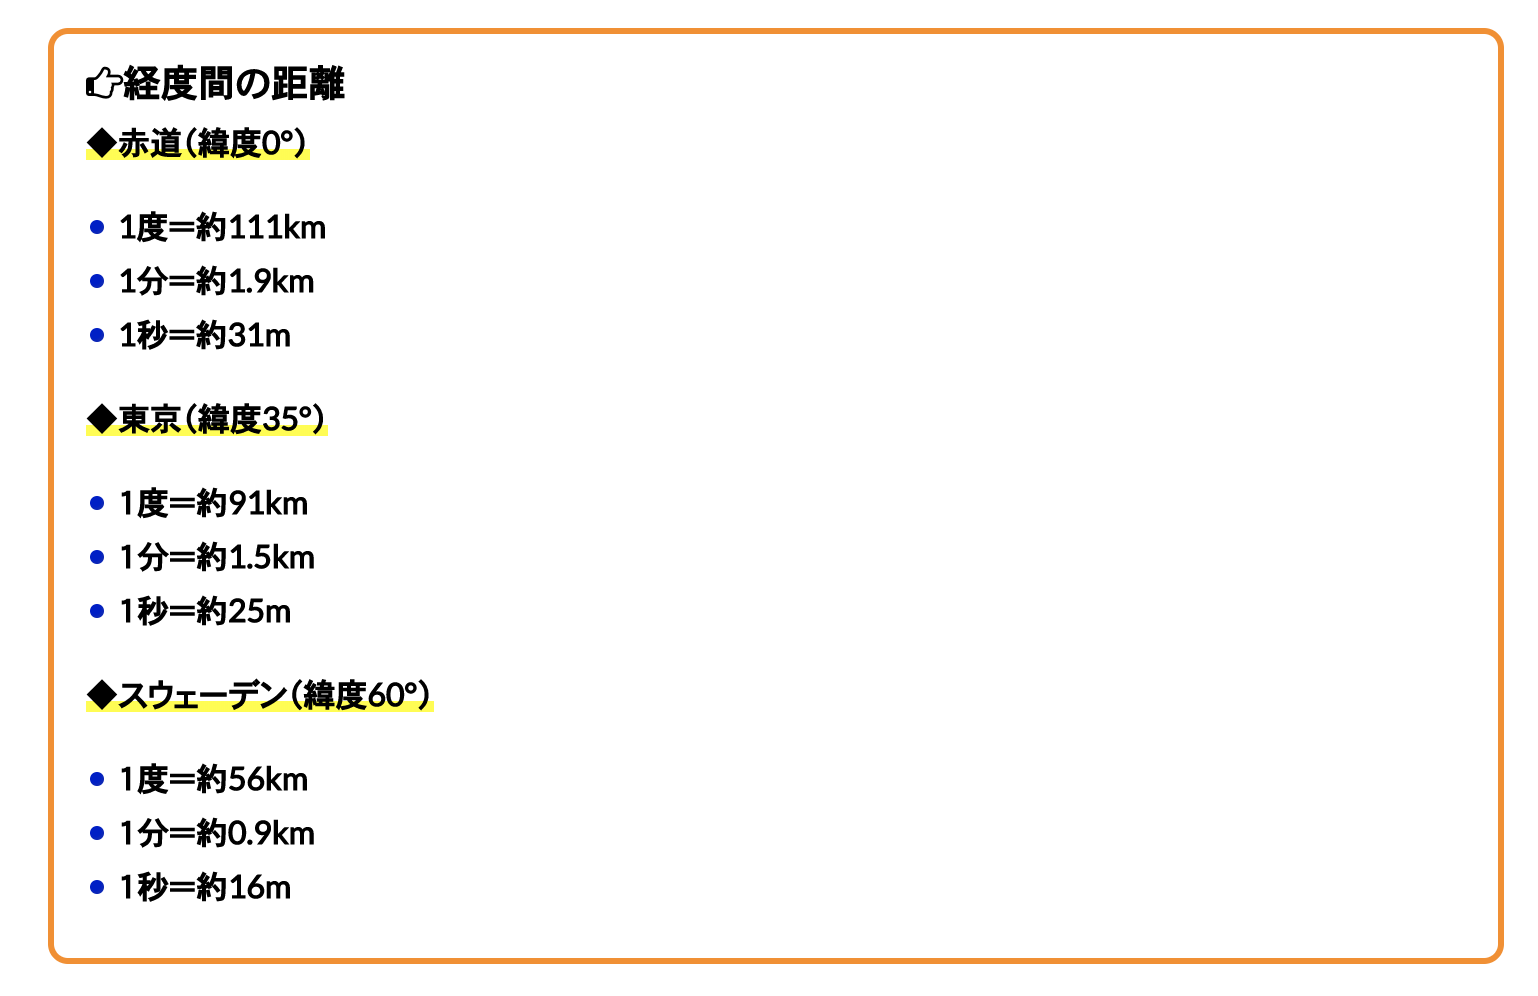

In [12]:
Image('./markdown/LatitudeLongitude.png')

- なので、一見同じでも、現在の表示上は異なる

- 名前はユニークに保管

In [13]:
df.loc[df.name.isnull(),'name'] = pd.Series([ 'name_'+str(_i) for _i in range(len(df.name.isnull()))])

### host name
- Nameと同様の処理を行なう

In [14]:
df[df.host_name.isnull()]

id                                               name    host_id  \
360      100184                                          Bienvenue     526653   
2700    1449546                            Cozy Studio in Flatbush    7779204   
5745    4183989    SPRING in the City!! Zen-Style Tranquil Bedroom     919218   
6075    4446862                 Charming Room in Prospect Heights!   23077718   
6582    4763327                Luxurious, best location, spa inc'l   24576978   
8163    6292866                          Modern Quiet Gem Near All   32722063   
8257    6360224                    Sunny, Private room in Bushwick   33134899   
8852    6786181                       R&S Modern Spacious Hideaway   32722063   
9138    6992973                    1 Bedroom in Prime Williamsburg    5162530   
9817    7556587                               Sunny Room in Harlem   39608626   
14040  10709846                 Sunny, spacious room in Greenpoint    7822683   
14631  11553543                                  Cozy Room Astoria   26138712   
15174  12113879     Sunny, Large West Village 1 BR Near Everything    5300585   
19565  15648096              Spacious 2 bedroom close to Manhattan  100971588   
27777  21787094         Spacious and Bright Midtown East Apartment     415290   
27962  21867710  Amazing room in the centre on Manhatten! Welcome!  159156636   
28042  21901156  Best Deal! Lovely place in Manhattan! Time Squ...  159156636   
28274  21990808                 ***SLEEPING IN THE GOLDEN PLACE***  159156636   
30570  23660605    Private Bedroom w/ Balcony view of Central Park  177146433   
32193  25180572                     Beautiful Cozy Studio Apt. UWS  119609345   
38992  30468335            LARGE Prospect Lefferts Gardens Bedroom  228750026   

      host_name neighbourhood_group     neighbourhood  latitude  longitude  \
360         NaN              Queens    Queens Village     40.72     -73.76   
2700        NaN            Brooklyn          Flatbush     40.65     -73.96   
5745        NaN           Manhattan            Harlem     40.81     -73.95   
6075        NaN            Brooklyn     Crown Heights     40.68     -73.96   
6582        NaN            Brooklyn        Greenpoint     40.72     -73.95   
8163        NaN            Brooklyn     East Flatbush     40.65     -73.93   
8257        NaN            Brooklyn          Bushwick     40.70     -73.93   
8852        NaN            Brooklyn     East Flatbush     40.64     -73.94   
9138        NaN            Brooklyn      Williamsburg     40.72     -73.96   
9817        NaN           Manhattan            Harlem     40.83     -73.94   
14040       NaN            Brooklyn        Greenpoint     40.74     -73.96   
14631       NaN              Queens  Ditmars Steinway     40.78     -73.92   
15174       NaN           Manhattan           Chelsea     40.74     -74.00   
19565       NaN               Bronx        Highbridge     40.84     -73.92   
27777       NaN           Manhattan   Upper East Side     40.76     -73.97   
27962       NaN           Manhattan    Hell's Kitchen     40.76     -73.99   
28042       NaN           Manhattan    Hell's Kitchen     40.76     -73.99   
28274       NaN           Manhattan    Hell's Kitchen     40.76     -73.99   
30570       NaN           Manhattan       East Harlem     40.80     -73.95   
32193       NaN           Manhattan   Upper West Side     40.78     -73.98   
38992       NaN            Brooklyn          Flatbush     40.65     -73.95   

             room_type  price  minimum_nights  number_of_reviews last_review  \
360       Private room     50               1                 43  2019-07-08   
2700   Entire home/apt    100              30                 49  2017-01-02   
5745      Private room     86               3                 34  2019-05-23   
6075      Private room     50               1                  0         NaN   
6582   Entire home/apt    195               1                  1  2015-10-20   
8163   Entire home/apt     85    

In [15]:
df[df.host_name.isnull()].groupby(['latitude','longitude']).count()['id']

latitude  longitude
40.64     -73.94       1
40.65     -73.96       1
          -73.95       1
          -73.93       1
40.68     -73.96       1
40.70     -73.93       1
40.72     -73.96       1
          -73.95       1
          -73.76       1
40.74     -73.96       1
          -74.00       1
40.76     -73.99       1
          -73.99       1
          -73.99       1
          -73.97       1
40.78     -73.92       1
          -73.98       1
40.80     -73.95       1
40.81     -73.95       1
40.83     -73.94       1
40.84     -73.92       1
Name: id, dtype: int64

- HostNameは欠損があるが、これらはそもそも信用して良いのかという問題がある。
- Nameに対しても同様のことが言える。
- ひとまず、hostname_接頭辞で番号で区別

In [16]:
df.loc[df.host_name.isnull(),'host_name'] = pd.Series([ 'hostname_'+str(_i) for _i in range(len(df.host_name.isnull()))])

### reviews_per_month
- 単純に、客が来ないor客が来てもコメントくれないということなので、0。
- この２点に関しては、この節で深堀りする必要はないと思う

In [17]:
df[df.reviews_per_month.isnull()]

id                                               name   host_id  \
2          3647                THE VILLAGE OF HARLEM....NEW YORK !      4632   
19         7750                  Huge 2 BR Upper East  Cental Park     17985   
26         8700  Magnifique Suite au N de Manhattan - vue Cloitres     26394   
36        11452                        Clean and Quiet in Brooklyn      7355   
38        11943                          Country space in the city     45445   
...         ...                                                ...       ...   
48890  36484665    Charming one bedroom - newly renovated rowhouse   8232441   
48891  36485057      Affordable room in Bushwick/East Williamsburg   6570630   
48892  36485431            Sunny Studio at Historical Neighborhood  23492952   
48893  36485609               43rd St. Time Square-cozy single bed  30985759   
48894  36487245  Trendy duplex in the very heart of Hell's Kitchen  68119814   

             host_name neighbourhood_group       neighbourhood  latitude  \
2            Elisabeth           Manhattan              Harlem     40.81   
19                Sing           Manhattan         East Harlem     40.80   
26     Claude & Sophie           Manhattan              Inwood     40.87   
36                  Vt            Brooklyn  Bedford-Stuyvesant     40.69   
38             Harriet            Brooklyn            Flatbush     40.64   
...                ...                 ...                 ...       ...   
48890          Sabrina            Brooklyn  Bedford-Stuyvesant     40.68   
48891          Marisol            Brooklyn            Bushwick     40.70   
48892    Ilgar & Aysel           Manhattan              Harlem     40.81   
48893              Taz           Manhattan      Hell's Kitchen     40.76   
48894       Christophe           Manhattan      Hell's Kitchen     40.76   

       longitude        room_type  price  minimum_nights  number_of_reviews  \
2         -73.94     Private room    150               3                  0   
19        -73.95  Entire home/apt    190               7                  0   
26        -73.93     Private room     80               4                  0   
36        -73.94     Private room     35              60                  0   
38        -73.96     Private room    150               1                  0   
...          ...              ...    ...             ...                ...   
48890     -73.95     Private room     70               2                  0   
48891     -73.93     Private room     40               4                  0   
48892     -73.95  Entire home/apt    115              10                  0   
48893     -73.99      Shared room     55               1                  0   
48894     -73.99     Private room     90               7                  0   

      last_review  reviews_per_month  calculated_host_listings_count  \
2             NaN                nan                               1   
19            NaN                nan                               2   
26            NaN                nan                               1   
36            NaN                nan                               1   
38            NaN                nan                               1   
...           ...                ...                             ...   
48890         NaN                nan                               2   
48891         NaN                nan                               2   
48892         NaN                nan                               1   
48893         NaN                nan                               6   
48894         NaN                nan                               1   

       availability_365  
2                   365  
19                  249  
26                    0  
36                  365  
38                  365  
...                 ...  
48890                 9  
48891                36  
48892                27  
48893                 2  
48894                23  

[10052 rows 

In [18]:
df.reviews_per_month.fillna(0,inplace=True)

### last_review はそもそも重要なのか
- reviews_pre_monthと同じことが言える
- 直近でレビューもらった数なんて..

In [19]:
df[df.last_review.isnull()]

id                                               name   host_id  \
2          3647                THE VILLAGE OF HARLEM....NEW YORK !      4632   
19         7750                  Huge 2 BR Upper East  Cental Park     17985   
26         8700  Magnifique Suite au N de Manhattan - vue Cloitres     26394   
36        11452                        Clean and Quiet in Brooklyn      7355   
38        11943                          Country space in the city     45445   
...         ...                                                ...       ...   
48890  36484665    Charming one bedroom - newly renovated rowhouse   8232441   
48891  36485057      Affordable room in Bushwick/East Williamsburg   6570630   
48892  36485431            Sunny Studio at Historical Neighborhood  23492952   
48893  36485609               43rd St. Time Square-cozy single bed  30985759   
48894  36487245  Trendy duplex in the very heart of Hell's Kitchen  68119814   

             host_name neighbourhood_group       neighbourhood  latitude  \
2            Elisabeth           Manhattan              Harlem     40.81   
19                Sing           Manhattan         East Harlem     40.80   
26     Claude & Sophie           Manhattan              Inwood     40.87   
36                  Vt            Brooklyn  Bedford-Stuyvesant     40.69   
38             Harriet            Brooklyn            Flatbush     40.64   
...                ...                 ...                 ...       ...   
48890          Sabrina            Brooklyn  Bedford-Stuyvesant     40.68   
48891          Marisol            Brooklyn            Bushwick     40.70   
48892    Ilgar & Aysel           Manhattan              Harlem     40.81   
48893              Taz           Manhattan      Hell's Kitchen     40.76   
48894       Christophe           Manhattan      Hell's Kitchen     40.76   

       longitude        room_type  price  minimum_nights  number_of_reviews  \
2         -73.94     Private room    150               3                  0   
19        -73.95  Entire home/apt    190               7                  0   
26        -73.93     Private room     80               4                  0   
36        -73.94     Private room     35              60                  0   
38        -73.96     Private room    150               1                  0   
...          ...              ...    ...             ...                ...   
48890     -73.95     Private room     70               2                  0   
48891     -73.93     Private room     40               4                  0   
48892     -73.95  Entire home/apt    115              10                  0   
48893     -73.99      Shared room     55               1                  0   
48894     -73.99     Private room     90               7                  0   

      last_review  reviews_per_month  calculated_host_listings_count  \
2             NaN               0.00                               1   
19            NaN               0.00                               2   
26            NaN               0.00                               1   
36            NaN               0.00                               1   
38            NaN               0.00                               1   
...           ...                ...                             ...   
48890         NaN               0.00                               2   
48891         NaN               0.00                               2   
48892         NaN               0.00                               1   
48893         NaN               0.00                               6   
48894         NaN               0.00                               1   

       availability_365  
2                   365  
19                  249  
26                    0  
36                  365  
38                  365  
...                 ...  
48890                 9  
48891                36  
48892                27  
48893                 2  
48894                23  

[10052 rows 

- nullであるものに関しては、そもそも過去にreviewが無いことに起因している。

In [20]:
set(df[df.last_review.isnull()].number_of_reviews)

{0}

- 型変換

In [21]:
df.last_review = pd.to_datetime(df.last_review,format='%Y-%m-%d')

In [22]:
df.last_review

0       2018-10-19
1       2019-05-21
2              NaT
3       2019-07-05
4       2018-11-19
           ...    
48890          NaT
48891          NaT
48892          NaT
48893          NaT
48894          NaT
Name: last_review, Length: 48895, dtype: datetime64[ns]

In [23]:
date_recently = df.last_review.max()
df['days_no_review'] = (date_recently- df.last_review).apply(lambda _date: _date.days)

- データ取得時点でhostが何日レビューをもらっていないのか。累積の確率密度を示す
    - 最終利用日から何日経過しているのかを調べるのは有効ではある。
    - 今回、最終利用日とレビュー率とかわからないので、Airbnbの各ホストの有効利用のされ方はわからない。
        - よって、しょうがなくreviewをみて、全ホスト中どれくらい「いま」利用されているのかに「近いもの」を示している。
    - 図の説明をすると
        - 10日以内が10%
        - 50日以内が５０％
        - 120日以内が6０％
        - 3024日まで緩やかに
    - 要は稼働率は、おそらく結構低い事がわかる。
- 説明能力が低いのでこのカラム自体を消す。
    - number of reviewで事が足りる。

3024 8.284931506849315


(0, 1000)

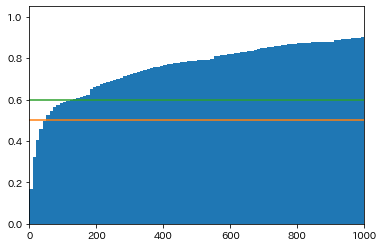

In [24]:
_date_max = int(df.days_no_review.max())
print(_date_max,_date_max/365)
plt.hist(df.days_no_review.dropna(),bins=range(0,_date_max,10),density=True,cumulative=True)
plt.plot(range(_date_max),[0.5 for i in range(_date_max)])
plt.plot(range(_date_max),[0.6 for i in range(_date_max)])
plt.xlim([0,1000])

In [25]:
del df['last_review']

In [26]:
df.days_no_review.fillna(_date_max,inplace=True)

# 各feature確認

In [27]:
df.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
days_no_review                    float64
dtype: object

In [28]:
#お部屋タイプ
df.room_type.unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

In [29]:
#エリア
df.neighbourhood_group.unique()

array(['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

In [30]:
#地名
df.neighbourhood.unique()

array(['Kensington', 'Midtown', 'Harlem', 'Clinton Hill', 'East Harlem',
       'Murray Hill', 'Bedford-Stuyvesant', "Hell's Kitchen",
       'Upper West Side', 'Chinatown', 'South Slope', 'West Village',
       'Williamsburg', 'Fort Greene', 'Chelsea', 'Crown Heights',
       'Park Slope', 'Windsor Terrace', 'Inwood', 'East Village',
       'Greenpoint', 'Bushwick', 'Flatbush', 'Lower East Side',
       'Prospect-Lefferts Gardens', 'Long Island City', 'Kips Bay',
       'SoHo', 'Upper East Side', 'Prospect Heights',
       'Washington Heights', 'Woodside', 'Brooklyn Heights',
       'Carroll Gardens', 'Gowanus', 'Flatlands', 'Cobble Hill',
       'Flushing', 'Boerum Hill', 'Sunnyside', 'DUMBO', 'St. George',
       'Highbridge', 'Financial District', 'Ridgewood',
       'Morningside Heights', 'Jamaica', 'Middle Village', 'NoHo',
       'Ditmars Steinway', 'Flatiron District', 'Roosevelt Island',
       'Greenwich Village', 'Little Italy', 'East Flatbush',
       'Tompkinsville', 'Asto

In [31]:
df.price.describe(percentiles=[0.25,0.50,0.75,1.0])

count   48895.00
mean      152.72
std       240.15
min         0.00
25%        69.00
50%       106.00
75%       175.00
100%    10000.00
max     10000.00
Name: price, dtype: float64

### 地域vs部屋タイプ on #hostname
- 結局、地域とタイプは限定される
- heatmap では二極化して、各区分で同じ数くらいいるけど、それぞれで値段の帯域が違う。特にブルックリン

In [32]:
def cal_set(a):
    return len(set(a))/float(len(set(df.host_name)))

In [33]:
df.neighbourhood_group.value_counts()

Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: neighbourhood_group, dtype: int64

In [34]:
df.room_type.value_counts()

Entire home/apt    25409
Private room       22326
Shared room         1160
Name: room_type, dtype: int64

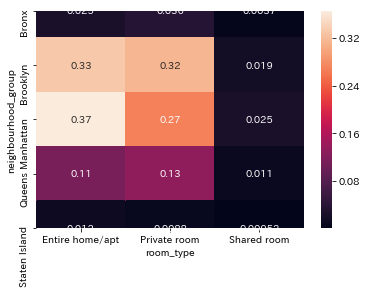

In [35]:
df_tmp = pd.pivot_table(df,index='neighbourhood_group',columns='room_type',values='host_name',aggfunc=cal_set)
sns.heatmap(data=df_tmp, annot=True)

### Price　on 地域 
- 地域ごとにpriceの差がある。
    - 外れ値を無視して考える。
        - 構成の観点からは、マンハッタン＞ブルックリン＞他
            - ブレイクダウンしても同様で、さらに顕著に出ている
        - 他のものであれば、Bronxが若干劣っている
    - 外れ値では、どの地域にも高い物件が存在する
    
- 以上から、ブレイクダウンした結果(結合)を用いることがベストであると思う

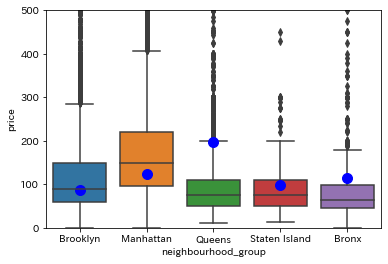

In [36]:
col = 'neighbourhood_group'
df_tmp_mean = df.groupby(col)['price'].mean()
plt.ylim([0,500])
ax = sns.boxplot(x=col,y='price',data=df)
for i, _label in enumerate(ax.get_xticklabels()):
    plt.plot(i,df_tmp_mean[i],marker='o', markersize=10,color='b')
# for _key in list(set(df[col])):
#     df_stat = df.loc[df[col] == _key].price.describe()

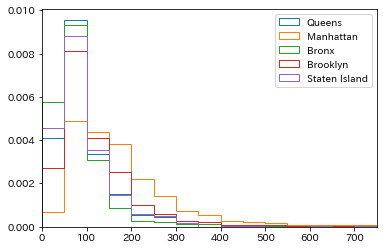

In [37]:
for i, _label in enumerate(set(df[col])):
    plt.hist(df[df[col]==_label]['price'],label=_label,bins=range(0,10000,50),density=True,alpha=1, histtype="step")
plt.xlim(0,750)
plt.legend()


In [38]:
ls_order_graph_tmp = [ _group+'-'+_type  for _type in set(df.room_type) for _group in set(df.neighbourhood_group)]

([<matplotlib.axis.XTick at 0x120e1e278>,
 <a list of 15 Text xticklabel objects>)

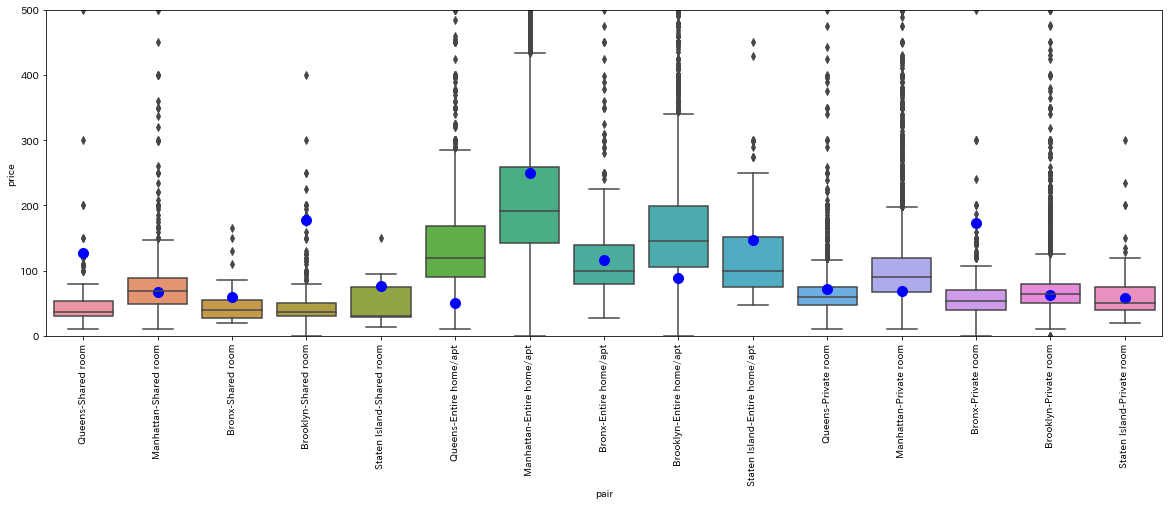

In [39]:
col = 'pair'
df['pair'] = df.neighbourhood_group + '-'+df.room_type
df_tmp_mean = df.groupby(col)['price'].mean()
fig = plt.figure(figsize=(20.0, 6.0))
plt.ylim([0,500])
ax = sns.boxplot(x=col,y='price',data=df,order=ls_order_graph_tmp)
for i, _label in enumerate(ax.get_xticklabels()):
    plt.plot(i,df_tmp_mean[i],marker='o', markersize=10,color='b')
# for _key in list(set(df[col])):
#     df_stat = df.loc[df[col] == _key].price.describe()
plt.xticks(range(len(ax.get_xticklabels())), ax.get_xticklabels(), rotation=90)

In [40]:
### 

### 場所ごと
- 場所に関してどの程度Hostが居るのか
    - 対数取るときれいに線形
        - 場所に関するメタ的な特性が無い
        - テキストとして処理することは問題がある。
- 歯科としてもいいと思う。

<BarContainer object of 221 artists>

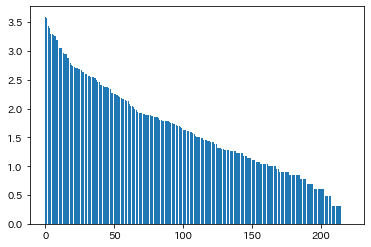

In [41]:
plt.bar(range(len(df.neighbourhood.value_counts())),np.log10(df.neighbourhood.value_counts().values))

In [42]:
df['neighbourhood_group-room_type'] = df.neighbourhood_group + '-' +df.room_type

## mim-stay vs price
- min-nightはそもそもログにしたほうがいいので、logにする。
- 少min-nightの方では、線形に減る傾向にある。
- priceが非常に高いhostを除外した場合、min-stayごとにpriceの分布は変わらない。
    - priceが非常に高いhostは減少傾向にはある。 

In [43]:
df.minimum_nights.describe()

count   48895.00
mean        7.03
std        20.51
min         1.00
25%         1.00
50%         3.00
75%         5.00
max      1250.00
Name: minimum_nights, dtype: float64

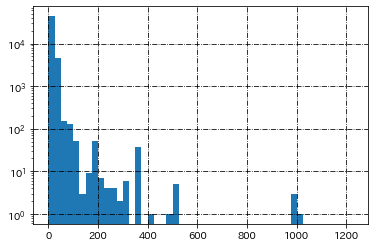

In [44]:

plt.grid(which='major',color='black',linestyle='-.')
plt.hist(df.minimum_nights,bins=range(0,1250,25))
# plt.grid(which='minor',color='black',linestyle='-.')
plt.yscale('log')

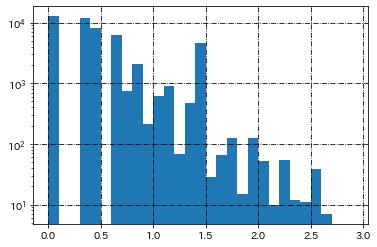

In [45]:
plt.hist(np.log10(df.minimum_nights),bins=[ i/1000.0 for i in range(0,3000,100)])
plt.grid(which='major',color='black',linestyle='-.')
# plt.grid(which='minor',color='black',linestyle='-.')
plt.yscale('log')

In [46]:
df['log_minimum_nights'] = np.log10(df.minimum_nights)

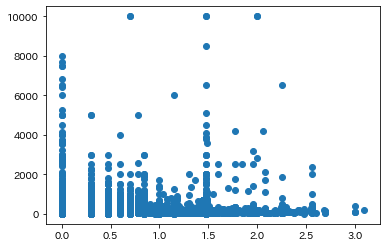

In [47]:
plt.scatter(df.log_minimum_nights,df.price)

In [48]:
ls_ctgr_log_night = [ i/10.0 for i in range(0,35,5)]
df['ctgr_log_minimum_nights'] = pd.cut(df['log_minimum_nights'],bins=ls_ctgr_log_night)
df['ctgr_log_minimum_nights'] = df['ctgr_log_minimum_nights'].cat.add_categories('0')
df['ctgr_log_minimum_nights'].fillna('0',inplace=True)

(0, 500)

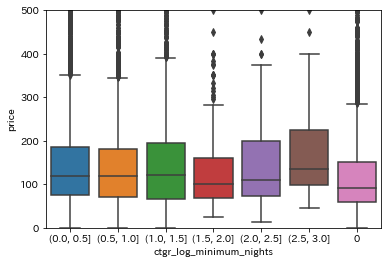

In [49]:
sns.boxplot(x='ctgr_log_minimum_nights',y='price',data=df)
plt.ylim(0,500)

### aviilable
- きれいに線形になっている。
- 但し、0が非常に多いので、0だけは区別する。Norevieｗの確信度を上げるため

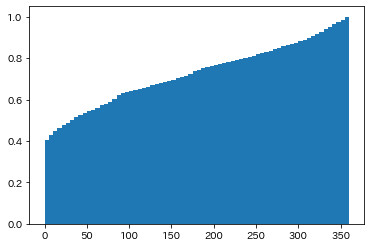

In [50]:
plt.hist(df.availability_365,bins=range(0,365,5),density=True,cumulative=True)
df['rate_availability'] = df.availability_365/365.0
df['no_availability'] = df.availability_365 == 0

### Nameを分析

In [51]:
df['lower_name'] = df.name.str.lower()

In [52]:
#短縮後辞書
shortened = {
    'w//':'with',
    '\'m': ' am',
    '\'re': ' are',
    'don\'t': 'do not',
    'doesn\'t': 'does not',
    'didn\'t': 'did not',
    'have\'t': 'have not',
    'won\'t': 'will not',
    'wanna': 'want to',
    'gonna': 'going to',
    'gotta': 'got to',
    'hafta': 'have to',
    'needa': 'need to',
    'outta': 'out of',
    'kinda': 'kind of',
    'sorta': 'sort of',
    'lotta': 'lot of',
    'lemme': 'let me',
    'gimme': 'give me',
    'getcha': 'get you',
    'gotcha': 'got you',
    'letcha': 'let you',
    'betcha': 'bet you',
    'shoulda': 'should have',
    'coulda': 'could have',
    'woulda': 'would have',
    'musta': 'must have',
    'mighta': 'might have',
    'dunno': 'do not know',
    'bdrm': 'bedroom',#カスタム
    'apt': 'apartment',#カスタム
    'apart': 'apartment',#カスタム
    'bed room': 'bedroom',#カスタム
    'nyc': 'newyork',#カスタム
    'new york': 'newyork',#カスタム
    'times square': 'timessquare',#カスタム
}


In [53]:
wnl = WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = frozenset(stopwords.words('english'))
shortened_re = re.compile('(?:' + '|'.join(map(lambda x: '\\b' + x + '\\b', shortened.keys())) + ')')

In [54]:
def convert_text(sentence):
    sentence = shortened_re.sub(lambda x: shortened[x.group(0)], sentence)#短縮後を戻す(人工的に)
    sentence = (re.sub(r"[^\w']+"," ",sentence))
    sentence = (re.sub(r"[0-9]+"," ",sentence))
    sentence = nltk.word_tokenize(sentence)#単語分割
    sentence = list(filter(lambda x: x not in stop_words, sentence)) #stopwordを消す
    sentence = list(map(stemmer.stem, sentence)) #stemming　going->go
    sentence = list(map(wnl.lemmatize, sentence))#lemm stemmingとほぼ同じ。見出し語かしてくれるらしい。

    return sentence


In [55]:
df['lower_name_edited'] = df.lower_name.apply(lambda x: convert_text(x))

## Price vs HostName
- 各Hostnameを１つのDocument とみなす

- 文書作成

In [56]:
ls_ls_words = [_doc for _doc in df.lower_name_edited]
dictionary = gensim.corpora.Dictionary(ls_ls_words)
dictionary.filter_extremes(no_below=20, no_above=0.4)#float:ratio, imteger: count
corpus = [dictionary.doc2bow(ls_words) for ls_words in ls_ls_words]

In [57]:
#保存
dictionary.save('./tmp_data/words_dict.dict')
corpora.MmCorpus.serialize('./tmp_data/corpus.mm', corpus)

In [58]:
N_TOPIC = 5

In [59]:
lda = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=N_TOPIC, id2word=dictionary)

In [60]:
for i_topic in range(N_TOPIC):
    ls_topic = lda.show_topic(i_topic)
    print("\n")
    print("="*80)
    for _topic in ls_topic:
        print("{0:20s}{1}".format(_topic[0], _topic[1]))



park                0.07636097818613052
near                0.062316544353961945
apart               0.055293962359428406
central             0.051511745899915695
spaciou             0.03211618959903717
brooklyn            0.027348265051841736
timessquar          0.027072066441178322
bedroom             0.02606734074652195
room                0.022292936220765114
garden              0.020956937223672867


room                0.06159086152911186
williamsburg        0.052931591868400574
privat              0.04508431628346443
loft                0.04071612283587456
bushwick            0.03534860163927078
bedroom             0.03337999805808067
heart               0.03047529049217701
new                 0.028108227998018265
brooklyn            0.025896482169628143
's                  0.021697906777262688


w                   0.04579651355743408
home                0.04377566650509834
br                  0.04244570806622505
villag              0.03767867013812065
privat              0.0

In [61]:

dictionary.save('/tmp/deerwester.dict')

In [62]:
df_topic = pd.DataFrame({ i_row: { 'topic_'+str(_topic[0]) : _topic[1] for _topic in lda.get_document_topics(corpus[i_row]) } for i_row in range(len(df)) })
df_topic = df_topic.T

In [63]:
df.head()

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington     40.65     -73.97   
1     Jennifer           Manhattan       Midtown     40.75     -73.98   
2    Elisabeth           Manhattan        Harlem     40.81     -73.94   
3  LisaRoxanne            Brooklyn  Clinton Hill     40.69     -73.96   
4        Laura           Manhattan   East Harlem     40.80     -73.94   

         room_type  price  ...  availability_365  days_no_review  \
0     Private room    149  ...               365          262.00   
1  Entire home/apt    225  ...               355           48.00   
2     Private room    150  ...               365         3024.00   
3  Entire home/apt     89  ...               194            3.00   
4  Entire home/apt     80  ...                 0          231.00   

                        pair  neighbourhood_group-room_type  \
0      Brooklyn-Private room          Brooklyn-Private room   
1  Manhattan-Entire home/apt      Manhattan-Entire home/apt   
2     Manhattan-Private room         Manhattan-Private room   
3   Brooklyn-Entire home/apt       Brooklyn-Entire home/apt   
4  Manhattan-Entire home/apt      Manhattan-Entire home/apt   

   log_minimum_nights  ctgr_log_minimum_nights rate_availability  \
0                0.00                        0              1.00   
1                0.00                        0              0.97   
2                0.48               (0.0, 0.5]              1.00   
3                0.00                        0              0.53   
4                1.00               (0.5, 1.0]              0.00   

  no_availability                                        lower_name  \
0           False                clean & quiet apt home by the park   
1           False                             skylit midtown castle   
2           False               the village of harlem....new york !   
3           False                   cozy entire floor of brownstone   
4            True  entire apt: spacious studio/loft by central park   

                                   lower_name_edited  
0                  [clean, quiet, apart, home, park]  
1                           [skylit, midtown, castl]  
2                          [villag, harlem, newyork]  
3                    [cozi, entir, floor, brownston]  
4  [entir, apart, spaciou, studio, loft, central,...  

[5 rows x 24 columns]

In [64]:
df_processed = pd.concat([df,df_topic],axis=1,sort=True)

## 楽しそうな図たち

## kaggleから引用したコード群
- 1. 

In [146]:
import folium
m = folium.Map(location=[35.681382, 139.76608399999998], zoom_start=14) #東京駅の緯度経度
m

In [153]:
import folium
from folium.plugins import MarkerCluster
from folium import plugins
print('Rooms with the most number of reviews')
Long=-73.80
Lat=40.80
mapdf1=folium.Map([Lat,Long],zoom_start=10,)

mapdf1_rooms_map=plugins.MarkerCluster().add_to(mapdf1)

for lat,lon,label in zip(df[:10].latitude,df[:10].longitude,df[:10].name):
    folium.Marker(location=[lat,lon],icon=folium.Icon(icon='home'),popup=label).add_to(mapdf1_rooms_map)
    
mapdf1.add_child(mapdf1_rooms_map)


Rooms with the most number of reviews


- 2. #営業日を地域ごとにプロットしてみた

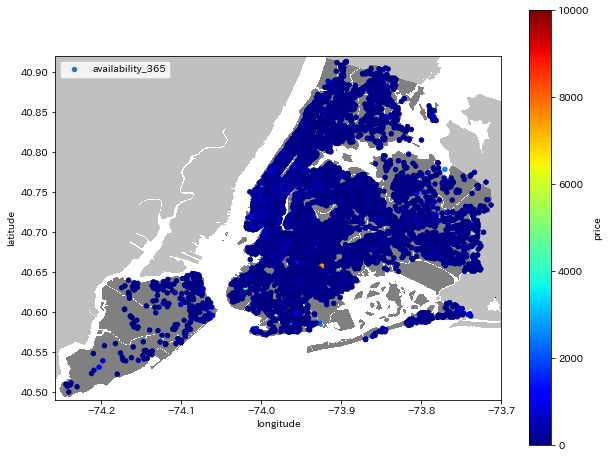

In [156]:
import urllib
#initializing the figure size
plt.figure(figsize=(10,8))
#loading the png NYC image found on Google and saving to my local folder along with the project
i=urllib.request.urlopen('https://upload.wikimedia.org/wikipedia/commons/e/ec/Neighbourhoods_New_York_City_Map.PNG')
nyc_img=plt.imread(i)
#scaling the image based on the latitude and longitude max and mins for proper output
plt.imshow(nyc_img,zorder=0,extent=[-74.258, -73.7, 40.49,40.92])
ax=plt.gca()
#using scatterplot again
df.plot(kind='scatter', x='longitude', y='latitude', label='availability_365', c='price', ax=ax, 
           cmap=plt.get_cmap('jet'), colorbar=True, alpha=1, zorder=5)
plt.legend()
plt.show()

# 実際に予測してみるっていう一連の過程

https://www.kaggle.com/jrw2200/smart-pricing-with-xgb-rfr-interpretations#SUMMARY

### 特徴量選択

In [66]:
ls_cols_ctgr = [
    'ctgr_log_minimum_nights',
    'neighbourhood_group',
    'room_type',
    'no_availability',
]
ls_cols_num  = [   
    'availability_365', 
    'calculated_host_listings_count',
    'days_no_review',
    'latitude',
    'log_minimum_nights',
    'longitude',
    'minimum_nights', 
    'number_of_reviews',                
    'rate_availability',
    'reviews_per_month', 
    'topic_0',
    'topic_1',  
    'topic_2',
    'topic_3',                    
    'topic_4'
]

### データ分割とスケール変換、カテゴリ変数変換

In [71]:
df_cat = pd.concat([pd.get_dummies(df_processed[ls_cols_ctgr[i]],prefix=str(ls_cols_ctgr[i])) for i in range(len(ls_cols_ctgr))],axis=1)
df_num = df_processed[ls_cols_num]

In [72]:
X = pd.concat([df_cat,df_num], axis=1)

In [73]:
y = np.log10(df['price']+1)

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [77]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

###  評価
- RMSEで評価する
- 5FoldのCV

In [80]:
n_folds = 5
def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(ls_cols_num)
    return cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)

# def rmse_lv_cv(model):
#     kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(ls_cols_num)
#     return cross_val_score(model, Xlv_train, y_train, scoring='neg_mean_squared_error', cv=kf)

In [93]:
# for Model in [LinearRegression, Ridge, Lasso, ElasticNet, RandomForestRegressor, XGBRegressor, HuberRegressor]:
# for Model in [LinearRegression, Ridge, Lasso, ElasticNet, RandomForestRegressor, HuberRegressor,SVR,GradientBoostingRegressor]:
for Model in [LinearRegression, Ridge, Lasso, ElasticNet, RandomForestRegressor, HuberRegressor]:  
    cv_res = rmse_cv(Model())
    print('{}: {:.5f} +/- {:5f}'.format(Model.__name__, -cv_res.mean(), cv_res.std()))

LinearRegression: 0.04404 +/- 0.001201
Ridge: 0.04403 +/- 0.001204
Lasso: 0.09098 +/- 0.001450
ElasticNet: 0.09030 +/- 0.001388


/Users/macico/Dropbox/tanico_rikudo/deep/python3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/Users/macico/Dropbox/tanico_rikudo/deep/python3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/Users/macico/Dropbox/tanico_rikudo/deep/python3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/Users/macico/Dropbox/tanico_rikudo/deep/python3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/Users/macico/Dropbox/tanico_rikudo/deep/python3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value

RandomForestRegressor: 0.04056 +/- 0.001287
HuberRegressor: 0.04533 +/- 0.001182


### Ridge Regression
#### Hyperparameter optimization
- L2 正規項に関するアルファをCVの結果から最適化する
- Ridge modelの場合

In [81]:
alphas1 = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75] 
cv_ridge1 = [-rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas1]

In [82]:
alphas2 = [0.5*i for i in range(4,12)]
cv_ridge2 = [-rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas2]

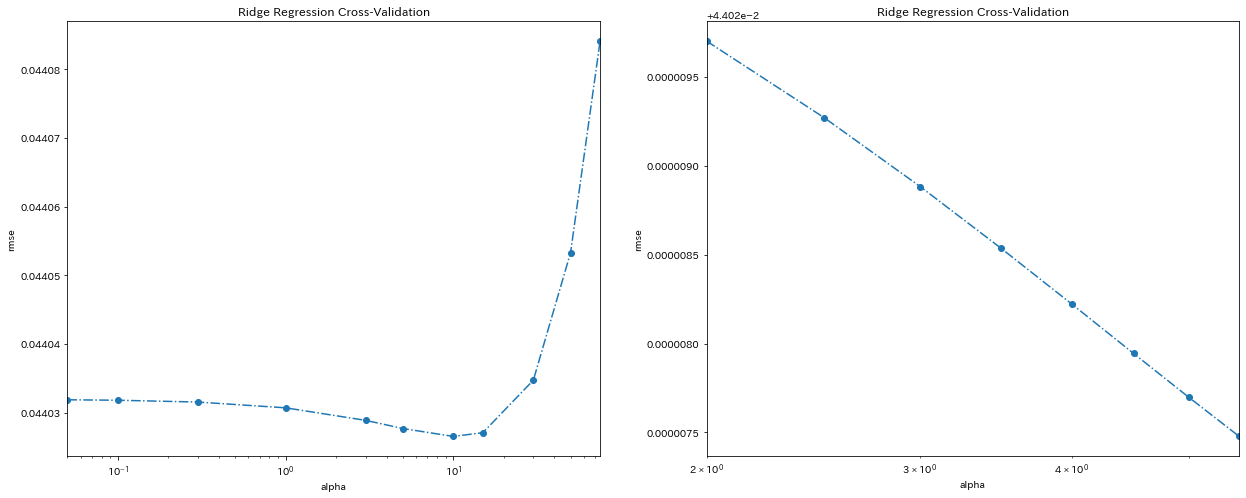

In [88]:
cv_ridge1 = pd.Series(cv_ridge1, index = alphas1) 
cv_ridge2 = pd.Series(cv_ridge2, index = alphas2) 

fig, axes = plt.subplots(1,2,figsize=(21, 8))
cv_ridge1.plot(title = "Ridge Regression Cross-Validation", style='-.o', ax = axes[0]) 
axes[0].set_xlabel("alpha") 
axes[0].set_ylabel("rmse")
axes[0].set_xscale('log')

cv_ridge2.plot(title = "Ridge Regression Cross-Validation", style='-.o', ax = axes[1]) 
axes[1].set_xlabel("alpha") 
axes[1].set_ylabel("rmse")
axes[1].set_xscale('log')


### testを使った評価

In [91]:
best_alpha = alphas2[np.argmin(cv_ridge2.values)]
RR_CV_best = -rmse_cv(Ridge(alpha = best_alpha))
RR = Ridge(alpha = best_alpha) 
RR.fit(X_train, y_train) 
y_train_RR = RR.predict(X_train)
y_test_RR = RR.predict(X_test)
ridge_results = pd.DataFrame({'algorithm':['Ridge Regression'],
            'CV error': RR_CV_best.mean(), 
            'CV std': RR_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_RR)],
            'test error':   [mean_squared_error(y_test_RR, y_test_RR)],
            'training_r2_score': [r2_score(y_train, y_train_RR)],
            'test_r2_score':     [r2_score(y_test,  y_test_RR)]})
ridge_results

algorithm  CV error  CV std  training error  test error  \
0  Ridge Regression      0.04    0.00            0.04        0.00   

   training_r2_score  test_r2_score  
0               0.52           0.53

In [98]:

from sklearn.preprocessing import scale, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet,  HuberRegressor

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.utils import resample

# from xgboost import XGBRegressor

#Model interpretation modules
import eli5
import lime
import lime.lime_tabular
import shap
shap.initjs()

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [105]:
dct_ctgr_index = { list(X.columns).index(col_ctgr) : col_ctgr for col_ctgr in list(df_cat.columns)}

In [107]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train, 
    feature_names=X.columns, 
    class_names=['price'], 
    verbose=True, 
    mode='regression',
    categorical_features=dct_ctgr_index.keys(),
    categorical_names=dct_ctgr_index.values()
)


 - Predicted Value:モデルの予測値
     - min/maxはトレーニングデータでの予測値の最大/最小
 - Positive/Negativeの横棒グラフは各因子が目的変数（PRICE）に対してpositive（価格を上げる）方向に寄与している or negative（価格を下げる）に寄与している
 - Feature/Valueは説明対象としたサンプルの説明変数の値

In [123]:
def export_result_lime(idx):
    exp = explainer.explain_instance(
        X_test[idx], 
        RR.predict, 
        num_features=10#(len(X.columns))
    )
    exp.show_in_notebook(show_table=True)

In [125]:
export_result_lime(0)
export_result_lime(5)
export_result_lime(78)
export_result_lime(395)

Intercept 1.5492482008422326
Prediction_local [2.1563081]
Right: 2.236993372994987


Intercept 1.4542370236779343
Prediction_local [2.17387148]
Right: 2.0633747208288464


Intercept 1.4939615901946457
Prediction_local [2.16246497]
Right: 2.045205463743052


Intercept 1.756302924246646
Prediction_local [1.90255651]
Right: 1.9354525457696115


## shap
- 右側にいくほど寄与が正の向きに大きく、左側にいくほど寄与が負の向きに大きい
- 顕著な例では、緯度で青(低め)がSHAP高めに居る。これは、緯度が低いとそれだけpriceアップに寄与していることになる。


 - 一応、バイアスは避けられている
     - https://aotamasaki.hatenablog.com/entry/bias_in_feature_importances

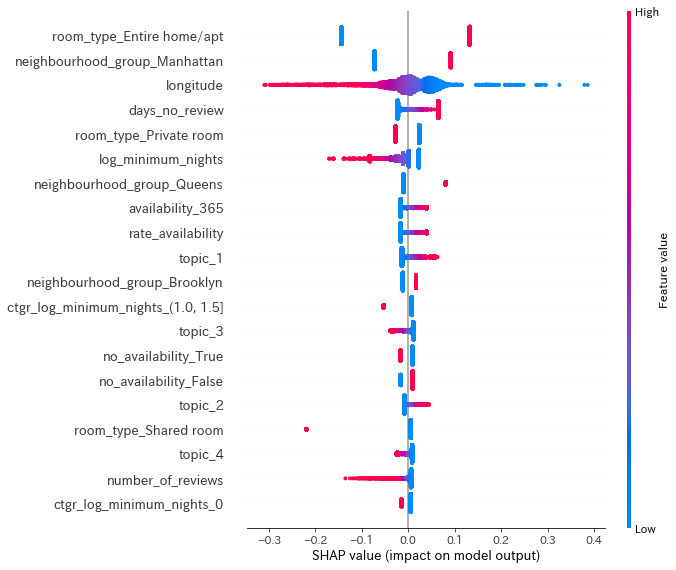

In [126]:
# explainer = shap.TreeExplainer(bst)
explainer_sh = shap.LinearExplainer(RR, X_train, feature_dependence='independent')
shap_values = explainer_sh.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

- 単一ポイント限定

In [133]:
shap.force_plot(explainer_sh.expected_value, shap_values[0,:], X_test[0,:])

- 総合的にはんだんされたもの

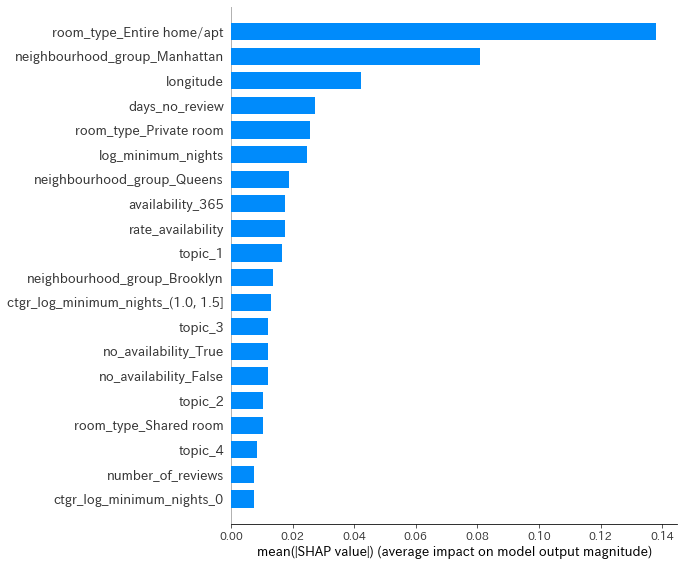

In [128]:

shap.summary_plot(shap_values, X_test, plot_type="bar",feature_names=X.columns)

## Lassoの場合はどうなるんかって、同じようにやってみる

In [134]:
alphas = [0.0001, 0.001, 0.005,0.01, 0.05, 0.1, 0.3, 1] 
cv_lasso = [-rmse_cv(Lasso(alpha = alpha, max_iter=2000)).mean() for alpha in alphas]

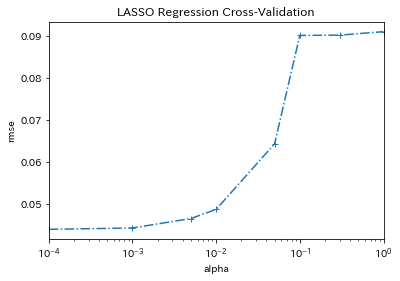

In [138]:
cv_lasso = pd.Series(cv_lasso, index = alphas) 
cv_lasso.plot(title = "LASSO Regression Cross-Validation", style='-.+') 
plt.xlabel("alpha") 
plt.ylabel("rmse") 
plt.xscale('log')

In [139]:
best_alpha = alphas[np.argmin(cv_lasso.values)]
lasso_CV_best = -rmse_cv(Lasso(alpha = best_alpha))
lasso = Lasso(alpha = best_alpha) 
lasso.fit(X_train, y_train) 
y_train_lasso = lasso.predict(X_train)
y_test_lasso = lasso.predict(X_test)
lasso_results = pd.DataFrame({'algorithm':['LASSO Regression'],
            'CV error': lasso_CV_best.mean(), 
            'CV std': lasso_CV_best.std(),
            'training error': [mean_squared_error(y_train_lasso, y_train)],
            'test error': [mean_squared_error(y_test_lasso, y_test)],
            'training_r2_score': [r2_score(y_train, y_train_lasso)],
            'test_r2_score': [r2_score(y_test, y_test_lasso)]})
lasso_results

algorithm  CV error  CV std  training error  test error  \
0  LASSO Regression      0.04    0.00            0.04        0.04   

   training_r2_score  test_r2_score  
0               0.52           0.53

2.3 LASSO Regression
2.3.0 Hyperparameter optimization
The training error for LASSO is somewhat higher than for Ridge (~0.198 vs ~0.197). However, the difference is quite small so that LASSO is still useful - for one as, a variable selector!

In [140]:
features = list(df_cat.columns) + list(df_num.columns)
coef = pd.Series(lasso.coef_, index = features)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 24 variables and eliminated the other 8 variables


In [141]:
coef

ctgr_log_minimum_nights_(0.0, 0.5]    0.01
ctgr_log_minimum_nights_(0.5, 1.0]    0.00
ctgr_log_minimum_nights_(1.0, 1.5]   -0.06
ctgr_log_minimum_nights_(1.5, 2.0]    0.00
ctgr_log_minimum_nights_(2.0, 2.5]   -0.00
ctgr_log_minimum_nights_(2.5, 3.0]    0.00
ctgr_log_minimum_nights_0            -0.01
neighbourhood_group_Bronx            -0.00
neighbourhood_group_Brooklyn         -0.00
neighbourhood_group_Manhattan         0.14
neighbourhood_group_Queens            0.06
neighbourhood_group_Staten Island    -0.32
room_type_Entire home/apt             0.33
room_type_Private room               -0.00
room_type_Shared room                -0.17
no_availability_False                 0.05
no_availability_True                 -0.00
availability_365                      0.04
calculated_host_listings_count       -0.00
days_no_review                        0.03
latitude                             -0.01
log_minimum_nights                   -0.05
longitude                            -0.06
minimum_nig

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

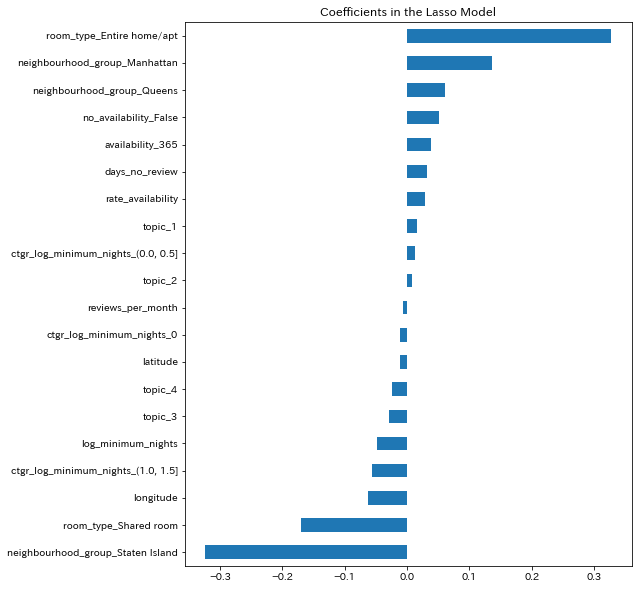

In [142]:
imp_coef = pd.concat([coef.sort_values().iloc[:10],
                     coef.sort_values().iloc[-10:]])
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [112]:
i=25
exp = explainer.explain_instance(X_test[i], lasso.predict, num_features=5)


Intercept 1.623887774464659
Prediction_local [2.41191699]
Right: 2.311514542218147


In [113]:
exp.show_in_notebook(show_table=True)